## 作业描述：

### ✓代码跑通

请大家根据课上所学内容，在 MyDNN类中补全代码，构造DNN网络，保证程序跑通。

### ✓调优

思考并动手进行调优，以在验证集上的准确率为评价指标，验证集上准确率越高，得分越高！

# **任务描述：**

### 本次实践是一个多分类任务，需要将照片中的宝石分别进行识别，完成**宝石的识别**

### **实践平台：百度AI实训平台-AI Studio、PaddlePaddle1.8.0 动态图**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


# 深度神经网络(DNN)

### **深度神经网络（Deep Neural Networks，简称DNN）是深度学习的基础，其结构为input、hidden（可有多层）、output，每层均为全连接。**
![](https://ai-studio-static-online.cdn.bcebos.com/c60fc28848cf469fa3a7824aa637a03f3b2b213ce7b84659919cb24b4430bffb)



# 数据集介绍

* **数据集文件名为archive_train.zip,archive_test.zip。**

* **该数据集包含25个类别不同宝石的图像。**

* **这些类别已经分为训练和测试数据。**

* **图像大小不一，格式为.jpeg。**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data66363  dataset  readme.json


In [ ]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph import Linear
import matplotlib.pyplot as plt

# 1、数据准备

In [ ]:

'''
参数配置
'''
train_parameters = {
    "input_size": [3, 64, 64],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    'augment_path' : '/home/aistudio/augment',           #数据增强图片目录
    "src_path":"data/data66363/archive_train.zip",       #原始数据集路径
    "target_path":"/home/aistudio/data/dataset",        #要解压的路径 
    "train_list_path": "./train_data.txt",              #train_data.txt路径
    "eval_list_path": "./val_data.txt",                  #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "/home/aistudio/data/readme.json",   #readme.json路径
    "num_epochs": 20,                                    #训练轮数
    "train_batch_size": 64,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.001                                     #超参数学习率
    } 
}

In [ ]:
def unzip_data(src_path,target_path):

    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''

    if(not os.path.isdir(target_path)):    
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")


In [ ]:

def get_data_list(target_path,train_list_path,eval_list_path, augment_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # print(path)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)                       # 每张图片的路径
                if class_sum % 15 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目 
            # ----------------------------------数据增强----------------------------------
            aug_path = os.path.join(augment_path, class_dir)
            for img_path in os.listdir(aug_path):                                  # 遍历文件夹下的每个图片
                name_path = os.path.join(aug_path,img_path)                       # 每张图片的路径
                trainer_sum += 1 
                trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                all_class_images += 1                                   #所有类图片的数目
            # ----------------------------------------------------------------------------
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    print(train_parameters)
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    #乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [ ]:
def data_reader(file_list):
    '''
    自定义data_reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                img = Image.open(img_path) 
                if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                img = img.resize((64, 64), Image.BILINEAR)
                img = np.array(img).astype('float32') 
                img = img.transpose((2, 0, 1))  # HWC to CHW 
                img = img/255                   # 像素值归一化 
                yield img, int(lab) 
    return reader

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [ ]:


'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
augment_path = train_parameters['augment_path']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)


文件已解压


In [ ]:
def proc_img(src):
    for root, dirs, files in os.walk(src):
        if '__MACOSX' in root:continue
        for file in files:            
            src=os.path.join(root,file)
            img=Image.open(src)
            if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                    img.save(src)            


if __name__=='__main__':
    proc_img(r"data/dataset")


In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [ ]:
import os, Augmentor
import shutil, glob

if not os.path.exists(augment_path): # 控制不重复增强数据
    for root, dirs, files in os.walk("data/dataset", topdown=False):
        print(root,dirs,files,'1')
        for name in dirs:
            path_ = os.path.join(root, name)
            if '__MACOSX' in path_:continue
            print('数据增强：',os.path.join(root, name))
            print('image：',os.path.join(root, name))
            p = Augmentor.Pipeline(os.path.join(root, name),output_directory='output')
            p.rotate(probability=0.6, max_left_rotation=2, max_right_rotation=2)
            p.zoom(probability=0.6, min_factor=0.9, max_factor=1.1)
            p.random_distortion(probability=0.4, grid_height=2, grid_width=2, magnitude=1)

            count = 1000 - len(glob.glob(pathname=path_+'/*.jpg'))
            p.sample(count, multi_threaded=False)
            p.process()

    print('将生成的图片拷贝到正确的目录')
    for root, dirs, files in os.walk("data/dataset", topdown=False):
        for name in files:
            path_ = os.path.join(root, name)
            if path_.rsplit('/',3)[2] == 'output':
                type_ = path_.rsplit('/',3)[1]
                dest_dir = os.path.join(augment_path ,type_) 
                if not os.path.exists(dest_dir):os.makedirs(dest_dir) 
                dest_path_ = os.path.join(augment_path ,type_, name) 
                shutil.move(path_, dest_path_)
    print('删除所有output目录')
    for root, dirs, files in os.walk("data/dataset", topdown=False):
        for name in dirs:
            if name == 'output':
                path_ = os.path.join(root, name)
                shutil.rmtree(path_)
    print('完成数据增强')

Processing labradorite_24.jpg:   1%|          | 8/960 [00:00<00:17, 53.00 Samples/s]

data/dataset/Labradorite [] ['labradorite_6.jpg', 'labradorite_12.jpg', 'labradorite_14.jpg', 'labradorite_2.jpg', 'labradorite_27.jpg', 'labradorite_0.jpg', 'labradorite_18.jpg', 'labradorite_33.jpg', 'labradorite_8.jpg', 'labradorite_16.jpg', 'labradorite_26.jpg', 'labradorite_22.jpg', 'labradorite_40.jpg', 'labradorite_1.jpg', 'labradorite_11.jpg', 'labradorite_34.jpg', 'labradorite_17.jpg', 'labradorite_25.jpg', 'labradorite_35.jpg', 'labradorite_29.jpg', 'labradorite_43.jpg', 'labradorite_31.jpg', 'labradorite_38.jpg', 'labradorite_7.jpg', 'labradorite_13.jpg', 'labradorite_20.jpg', 'labradorite_19.jpg', 'labradorite_36.jpg', 'labradorite_21.jpg', 'labradorite_30.jpg', 'labradorite_24.jpg', 'labradorite_10.jpg', 'labradorite_28.jpg', 'labradorite_37.jpg', 'labradorite_32.jpg', 'labradorite_9.jpg', 'labradorite_15.jpg', 'labradorite_39.jpg', 'labradorite_23.jpg', 'labradorite_5.jpg'] 1
data/dataset/Jade [] ['jade_6.jpg', 'jade_18.jpg', 'jade_27.jpg', 'jade_11.jpg', 'jade_7.jpg', 'j

Processing labradorite_17.jpg:   2%|▏         | 15/960 [00:00<00:23, 39.49 Samples/s]Processing labradorite_20.jpg: 100%|██████████| 960/960 [00:20<00:00, 45.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x7F1C4AF63F50>: 100%|██████████| 40/40 [00:00<00:00, 160.25 Samples/s]                 
Processing jade_10.jpg:   1%|          | 12/972 [00:00<00:17, 56.19 Samples/s]

数据增强： data/dataset/Jade
image： data/dataset/Jade
Initialised with 28 image(s) found.
Output directory set to data/dataset/Jade/output.

Processing jade_20.jpg:   3%|▎         | 28/972 [00:00<00:13, 69.00 Samples/s]Processing jade_7.jpg: 100%|██████████| 972/972 [00:18<00:00, 53.39 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=290x290 at 0x7F1C4AF88150>: 100%|██████████| 28/28 [00:00<00:00, 168.04 Samples/s]
Processing danburite_11.jpg:   1%|          | 7/968 [00:00<00:32, 29.33 Samples/s]

数据增强： data/dataset/Danburite
image： data/dataset/Danburite
Initialised with 32 image(s) found.
Output directory set to data/dataset/Danburite/output.

Processing danburite_6.jpg:   2%|▏         | 18/968 [00:00<00:27, 34.64 Samples/s]Processing danburite_11.jpg: 100%|██████████| 968/968 [00:19<00:00, 50.91 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=640x640 at 0x7F1C4AF79350>: 100%|██████████| 32/32 [00:00<00:00, 154.78 Samples/s]                 
Processing iolite_14.jpg:   2%|▏         | 15/968 [00:00<00:11, 82.74 Samples/s]

数据增强： data/dataset/Iolite
image： data/dataset/Iolite
Initialised with 32 image(s) found.
Output directory set to data/dataset/Iolite/output.

Processing iolite_30.jpg:   3%|▎         | 30/968 [00:00<00:11, 82.96 Samples/s]Processing iolite_21.jpg: 100%|██████████| 968/968 [00:16<00:00, 59.73 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=290x290 at 0x7F1C4872F4D0>: 100%|██████████| 32/32 [00:00<00:00, 377.54 Samples/s]
Processing tanzanite_33.jpg:   1%|          | 5/964 [00:00<00:19, 49.76 Samples/s]

数据增强： data/dataset/Tanzanite
image： data/dataset/Tanzanite
Initialised with 36 image(s) found.
Output directory set to data/dataset/Tanzanite/output.

Processing tanzanite_21.jpg:   2%|▏         | 15/964 [00:00<00:22, 42.47 Samples/s]Processing tanzanite_13.jpg: 100%|██████████| 964/964 [00:22<00:00, 43.41 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=401x401 at 0x7F1C48720810>: 100%|██████████| 36/36 [00:00<00:00, 149.10 Samples/s]                 
Processing garnet red_17.jpg:   1%|          | 9/964 [00:00<00:18, 52.18 Samples/s]

数据增强： data/dataset/Garnet Red
image： data/dataset/Garnet Red
Initialised with 36 image(s) found.
Output directory set to data/dataset/Garnet Red/output.

Processing garnet red_2.jpg:   2%|▏         | 18/964 [00:00<00:17, 53.87 Samples/s] Processing garnet red_8.jpg: 100%|██████████| 964/964 [00:20<00:00, 47.70 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=301x301 at 0x7F1C48734D90>: 100%|██████████| 36/36 [00:00<00:00, 158.26 Samples/s]                 
Processing diamond_2.jpg:   1%|          | 7/969 [00:00<00:35, 27.40 Samples/s] 

数据增强： data/dataset/Diamond
image： data/dataset/Diamond
Initialised with 31 image(s) found.
Output directory set to data/dataset/Diamond/output.

Processing diamond_34.jpg:   1%|▏         | 13/969 [00:00<00:29, 32.89 Samples/s]Processing diamond_7.jpg: 100%|██████████| 969/969 [00:25<00:00, 38.46 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=330x330 at 0x7F1C4AF6FC50>: 100%|██████████| 31/31 [00:00<00:00, 124.43 Samples/s]                 
Processing carnelian_35.jpg:   1%|          | 10/967 [00:00<00:14, 65.40 Samples/s]

数据增强： data/dataset/Carnelian
image： data/dataset/Carnelian
Initialised with 33 image(s) found.
Output directory set to data/dataset/Carnelian/output.

Processing carnelian_15.jpg:   2%|▏         | 19/967 [00:00<00:15, 59.31 Samples/s]Processing carnelian_8.jpg: 100%|██████████| 967/967 [00:24<00:00, 39.64 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=401x401 at 0x7F1C48721290>: 100%|██████████| 33/33 [00:00<00:00, 174.50 Samples/s]                 
Processing beryl golden_20.jpg:   1%|▏         | 13/964 [00:00<00:13, 69.30 Samples/s]

数据增强： data/dataset/Beryl Golden
image： data/dataset/Beryl Golden
Initialised with 36 image(s) found.
Output directory set to data/dataset/Beryl Golden/output.

Processing beryl golden_8.jpg:   2%|▏         | 22/964 [00:00<00:14, 65.06 Samples/s]Processing beryl golden_8.jpg: 100%|██████████| 964/964 [00:16<00:00, 57.84 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=297x289 at 0x7F1C48732610>: 100%|██████████| 36/36 [00:00<00:00, 315.03 Samples/s]                  
Processing onyx black_16.jpg:   1%|          | 12/972 [00:00<00:16, 56.57 Samples/s]

数据增强： data/dataset/Onyx Black
image： data/dataset/Onyx Black
Initialised with 28 image(s) found.
Output directory set to data/dataset/Onyx Black/output.

Processing onyx black_4.jpg:   2%|▏         | 24/972 [00:00<00:16, 58.92 Samples/s] Processing onyx black_2.jpg: 100%|██████████| 972/972 [00:18<00:00, 52.39 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=201x189 at 0x7F1C48732790>: 100%|██████████| 28/28 [00:00<00:00, 164.65 Samples/s]                 
Processing emerald_22.jpg:   1%|          | 10/964 [00:00<00:19, 49.63 Samples/s]

数据增强： data/dataset/Emerald
image： data/dataset/Emerald
Initialised with 36 image(s) found.
Output directory set to data/dataset/Emerald/output.

Processing emerald_19.jpg:   2%|▏         | 18/964 [00:00<00:19, 48.26 Samples/s]Processing emerald_10.jpg: 100%|██████████| 964/964 [00:24<00:00, 39.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=311x311 at 0x7F1C4AF6F050>: 100%|██████████| 36/36 [00:00<00:00, 67.42 Samples/s]                  
Processing quartz beer_27.jpg:   1%|          | 9/965 [00:00<00:16, 56.62 Samples/s]

数据增强： data/dataset/Quartz Beer
image： data/dataset/Quartz Beer
Initialised with 35 image(s) found.
Output directory set to data/dataset/Quartz Beer/output.

Processing quartz beer_17.jpg:   2%|▏         | 21/965 [00:00<00:15, 60.05 Samples/s]Processing quartz beer_11.jpg: 100%|██████████| 965/965 [00:16<00:00, 59.19 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x7F1C48726310>: 100%|██████████| 35/35 [00:00<00:00, 213.20 Samples/s]                  
Processing alexandrite_37.jpg:   1%|▏         | 13/966 [00:00<00:14, 66.05 Samples/s]

数据增强： data/dataset/Alexandrite
image： data/dataset/Alexandrite
Initialised with 34 image(s) found.
Output directory set to data/dataset/Alexandrite/output.

Processing alexandrite_31.jpg:   3%|▎         | 25/966 [00:00<00:13, 71.47 Samples/s]Processing alexandrite_25.jpg: 100%|██████████| 966/966 [00:19<00:00, 50.07 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=395x395 at 0x7F1C48720F10>: 100%|██████████| 34/34 [00:00<00:00, 149.92 Samples/s]
Processing rhodochrosite_28.jpg:   1%|          | 9/971 [00:00<00:16, 59.80 Samples/s]

数据增强： data/dataset/Rhodochrosite
image： data/dataset/Rhodochrosite
Initialised with 29 image(s) found.
Output directory set to data/dataset/Rhodochrosite/output.

Processing rhodochrosite_12.jpg:   2%|▏         | 15/971 [00:00<00:21, 44.28 Samples/s]Processing rhodochrosite_25.jpg: 100%|██████████| 971/971 [00:20<00:00, 47.05 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=185x183 at 0x7F1C48721E10>: 100%|██████████| 29/29 [00:00<00:00, 170.06 Samples/s]                 
Processing sapphire blue_7.jpg:   1%|          | 11/966 [00:00<00:14, 66.05 Samples/s] 

数据增强： data/dataset/Sapphire Blue
image： data/dataset/Sapphire Blue
Initialised with 34 image(s) found.
Output directory set to data/dataset/Sapphire Blue/output.

Processing sapphire blue_32.jpg:   2%|▏         | 22/966 [00:00<00:14, 64.11 Samples/s]Processing sapphire blue_30.jpg: 100%|██████████| 966/966 [00:19<00:00, 49.05 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=290x290 at 0x7F1C4873A690>: 100%|██████████| 34/34 [00:00<00:00, 192.14 Samples/s]
Processing zircon_19.jpg:   1%|          | 7/967 [00:00<00:23, 41.47 Samples/s]

数据增强： data/dataset/Zircon
image： data/dataset/Zircon
Initialised with 33 image(s) found.
Output directory set to data/dataset/Zircon/output.

Processing zircon_33.jpg:   2%|▏         | 17/967 [00:00<00:21, 44.38 Samples/s]Processing zircon_1.jpg: 100%|██████████| 967/967 [00:24<00:00, 38.73 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=400x400 at 0x7F1C48720C90>: 100%|██████████| 33/33 [00:00<00:00, 144.04 Samples/s]                 
Processing variscite_15.jpg:   1%|          | 9/970 [00:00<00:21, 43.81 Samples/s]

数据增强： data/dataset/Variscite
image： data/dataset/Variscite
Initialised with 30 image(s) found.
Output directory set to data/dataset/Variscite/output.

Processing variscite_21.jpg:   2%|▏         | 23/970 [00:00<00:21, 43.50 Samples/s]Processing variscite_10.jpg: 100%|██████████| 970/970 [00:21<00:00, 45.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=290x290 at 0x7F1C487323D0>: 100%|██████████| 30/30 [00:00<00:00, 183.09 Samples/s]
Processing fluorite_14.jpg:   1%|          | 5/968 [00:00<00:53, 17.88 Samples/s]

数据增强： data/dataset/Fluorite
image： data/dataset/Fluorite
Initialised with 32 image(s) found.
Output directory set to data/dataset/Fluorite/output.

Processing fluorite_16.jpg:   1%|          | 10/968 [00:00<00:44, 21.55 Samples/s]Processing fluorite_14.jpg: 100%|██████████| 968/968 [00:22<00:00, 43.92 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=500x442 at 0x7F1C4872C290>: 100%|██████████| 32/32 [00:00<00:00, 146.85 Samples/s]                 
Processing cats eye_25.jpg:   1%|          | 6/969 [00:00<00:20, 46.48 Samples/s]

数据增强： data/dataset/Cats Eye
image： data/dataset/Cats Eye
Initialised with 31 image(s) found.
Output directory set to data/dataset/Cats Eye/output.

Processing cats eye_19.jpg:   2%|▏         | 15/969 [00:00<00:21, 44.65 Samples/s]Processing cats eye_31.jpg: 100%|██████████| 969/969 [00:25<00:00, 37.92 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=401x401 at 0x7F1C48731090>: 100%|██████████| 31/31 [00:00<00:00, 136.58 Samples/s]
Processing pearl_10.jpg:   1%|          | 11/967 [00:00<00:13, 69.28 Samples/s]

数据增强： data/dataset/Pearl
image： data/dataset/Pearl
Initialised with 33 image(s) found.
Output directory set to data/dataset/Pearl/output.

Processing pearl_14.jpg:   2%|▏         | 19/967 [00:00<00:15, 59.93 Samples/s]Processing pearl_30.jpg: 100%|██████████| 967/967 [00:18<00:00, 53.70 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=301x301 at 0x7F1C48739690>: 100%|██████████| 33/33 [00:00<00:00, 241.76 Samples/s]                 
Processing kunzite_21.jpg:   1%|          | 11/968 [00:00<00:10, 92.41 Samples/s]

数据增强： data/dataset/Kunzite
image： data/dataset/Kunzite
Initialised with 32 image(s) found.
Output directory set to data/dataset/Kunzite/output.

Processing kunzite_21.jpg:   2%|▏         | 20/968 [00:00<00:15, 59.63 Samples/s]Processing kunzite_27.jpg: 100%|██████████| 968/968 [00:16<00:00, 60.03 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x7F1C4872C390>: 100%|██████████| 32/32 [00:00<00:00, 360.70 Samples/s]                  
Processing almandine_29.jpg:   1%|          | 10/969 [00:00<00:20, 47.39 Samples/s]

数据增强： data/dataset/Almandine
image： data/dataset/Almandine
Initialised with 31 image(s) found.
Output directory set to data/dataset/Almandine/output.

Processing almandine_15.jpg:   2%|▏         | 18/969 [00:00<00:18, 50.86 Samples/s]Processing almandine_7.jpg: 100%|██████████| 969/969 [00:22<00:00, 42.84 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=521x497 at 0x7F1C48732250>: 100%|██████████| 31/31 [00:00<00:00, 109.57 Samples/s]
Processing benitoite_32.jpg:   1%|          | 10/969 [00:00<00:18, 51.99 Samples/s]

数据增强： data/dataset/Benitoite
image： data/dataset/Benitoite
Initialised with 31 image(s) found.
Output directory set to data/dataset/Benitoite/output.

Processing benitoite_23.jpg:   3%|▎         | 27/969 [00:00<00:14, 65.84 Samples/s]Processing benitoite_26.jpg: 100%|██████████| 969/969 [00:15<00:00, 62.28 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x400 at 0x7F1C4873A3D0>: 100%|██████████| 31/31 [00:00<00:00, 271.45 Samples/s]                  
Processing hessonite_9.jpg:   1%|          | 6/970 [00:00<00:48, 19.75 Samples/s] 

数据增强： data/dataset/Hessonite
image： data/dataset/Hessonite
Initialised with 30 image(s) found.
Output directory set to data/dataset/Hessonite/output.

Processing hessonite_6.jpg:   1%|▏         | 13/970 [00:00<00:36, 26.11 Samples/s] Processing hessonite_11.jpg: 100%|██████████| 970/970 [00:19<00:00, 48.58 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=301x301 at 0x7F1C4AF6F8D0>: 100%|██████████| 30/30 [00:00<00:00, 240.31 Samples/s]                
Processing malachite_4.jpg:   1%|          | 7/972 [00:00<00:19, 50.24 Samples/s] 

数据增强： data/dataset/Malachite
image： data/dataset/Malachite
Initialised with 28 image(s) found.
Output directory set to data/dataset/Malachite/output.

Processing malachite_28.jpg:   1%|▏         | 13/972 [00:00<00:20, 47.76 Samples/s]Processing malachite_4.jpg: 100%|██████████| 972/972 [00:19<00:00, 50.69 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=290x290 at 0x7F1C48731650>: 100%|██████████| 28/28 [00:00<00:00, 198.55 Samples/s]                 


将生成的图片拷贝到正确的目录
删除所有output目录
完成数据增强


In [ ]:



#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path,augment_path)

'''
构造数据提供器
'''
train_reader = paddle.batch(data_reader(train_list_path),
                            batch_size=batch_size,
                            drop_last=True)
eval_reader = paddle.batch(data_reader(eval_list_path),
                            batch_size=batch_size,
                            drop_last=True)
                            

{'input_size': [3, 64, 64], 'class_dim': 25, 'augment_path': '/home/aistudio/augment', 'src_path': 'data/data66363/archive_train.zip', 'target_path': '/home/aistudio/data/dataset', 'train_list_path': './train_data.txt', 'eval_list_path': './val_data.txt', 'label_dict': {'0': 'Labradorite', '1': 'Jade', '2': 'Danburite', '3': 'Iolite', '4': 'Tanzanite', '5': 'Garnet Red', '6': 'Diamond', '7': 'Carnelian', '8': 'Beryl Golden', '9': 'Onyx Black', '10': 'Emerald', '11': 'Quartz Beer', '12': 'Alexandrite', '13': 'Rhodochrosite', '14': 'Sapphire Blue', '15': 'Zircon', '16': 'Variscite', '17': 'Fluorite', '18': 'Cats Eye', '19': 'Pearl', '20': 'Kunzite', '21': 'Almandine', '22': 'Benitoite', '23': 'Hessonite', '24': 'Malachite'}, 'readme_path': '/home/aistudio/data/readme.json', 'num_epochs': 20, 'train_batch_size': 64, 'learning_strategy': {'lr': 0.001}}
生成数据列表完成！


In [ ]:
Batch=0
Batchs=[]
all_train_accs=[]
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

# 2、定义模型

### ###在以下cell中完成DNN网络的定义###

In [ ]:

#定义网络
class MyDNN(fluid.dygraph.Layer):
    '''
    卷积神经网络
    '''
    def __init__(self):
        super(MyDNN,self).__init__()
        self.hidden1=fluid.dygraph.Linear(3*64*64,1000, act='relu')
        self.hidden2=fluid.dygraph.Linear(1000,500, act='relu')
        self.hidden3=fluid.dygraph.Linear(500,100, act='relu')
        self.out = fluid.dygraph.Linear(input_dim=100, output_dim=25, act='softmax')

    def forward(self,input):
        x = fluid.layers.reshape(input,shape=[-1,3*64*64])
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

# 3、训练模型

In [17]:
with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):
    print(train_parameters['class_dim'])
    print(train_parameters['label_dict'])
    model=MyDNN() #模型实例化
    model.train() #训练模式
    opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    epochs_num=train_parameters['num_epochs'] #迭代次数
    
    for pass_num in range(epochs_num):
        for batch_id,data in enumerate(train_reader()):
            images = np.array([x[0] for x in data]).astype('float32').reshape(-1, 3,64,64)
            labels = np.array([x[1] for x in data]).astype('int64')
            labels = labels[:, np.newaxis]

            image=fluid.dygraph.to_variable(images)
            label=fluid.dygraph.to_variable(labels)

            predict=model(image) #数据传入model
            
            loss=fluid.layers.cross_entropy(predict,label)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            
            acc=fluid.layers.accuracy(predict,label)#计算精度
            
            if batch_id!=0 and batch_id%5==0:
                Batch = Batch+5 
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                all_train_accs.append(acc.numpy()[0])
                
                print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,avg_loss.numpy(),acc.numpy()))
            
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
    fluid.save_dygraph(model.state_dict(),'MyDNN')#保存模型

draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)

25
{'0': 'Labradorite', '1': 'Jade', '2': 'Danburite', '3': 'Iolite', '4': 'Tanzanite', '5': 'Garnet Red', '6': 'Diamond', '7': 'Carnelian', '8': 'Beryl Golden', '9': 'Onyx Black', '10': 'Emerald', '11': 'Quartz Beer', '12': 'Alexandrite', '13': 'Rhodochrosite', '14': 'Sapphire Blue', '15': 'Zircon', '16': 'Variscite', '17': 'Fluorite', '18': 'Cats Eye', '19': 'Pearl', '20': 'Kunzite', '21': 'Almandine', '22': 'Benitoite', '23': 'Hessonite', '24': 'Malachite'}


W0317 21:49:11.499866   879 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 10.1, Runtime API Version: 9.0
W0317 21:49:11.505533   879 device_context.cc:260] device: 0, cuDNN Version: 7.6.


train_pass:0,batch_id:5,train_loss:[3.1037416],train_acc:[0.125]
train_pass:0,batch_id:10,train_loss:[3.2158608],train_acc:[0.046875]
train_pass:0,batch_id:15,train_loss:[3.1386018],train_acc:[0.046875]
train_pass:0,batch_id:20,train_loss:[3.0935373],train_acc:[0.046875]
train_pass:0,batch_id:25,train_loss:[3.0680408],train_acc:[0.109375]
train_pass:0,batch_id:30,train_loss:[3.1759026],train_acc:[0.15625]
train_pass:0,batch_id:35,train_loss:[3.0858781],train_acc:[0.109375]
train_pass:0,batch_id:40,train_loss:[3.0137534],train_acc:[0.21875]
train_pass:0,batch_id:45,train_loss:[2.9993591],train_acc:[0.15625]
train_pass:0,batch_id:50,train_loss:[2.9882631],train_acc:[0.15625]
train_pass:0,batch_id:55,train_loss:[2.993816],train_acc:[0.203125]
train_pass:0,batch_id:60,train_loss:[3.019238],train_acc:[0.1875]
train_pass:0,batch_id:65,train_loss:[2.9680061],train_acc:[0.1875]
train_pass:0,batch_id:70,train_loss:[2.9253027],train_acc:[0.1875]
train_pass:0,batch_id:75,train_loss:[2.8863955],tr

KeyboardInterrupt: 

# 4、模型评估

In [18]:

#模型评估
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyDNN')
    model = MyDNN()
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    for batch_id,data in enumerate(eval_reader()):#测试集
        images = np.array([x[0] for x in data]).astype('float32').reshape(-1, 3,64,64)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]
        image=fluid.dygraph.to_variable(images)
        label=fluid.dygraph.to_variable(labels)       
        predict=model(image)       
        acc=fluid.layers.accuracy(predict,label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    print(avg_acc)

0.046875


# 5、模型预测

In [19]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path)):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img


infer_src_path = '/home/aistudio/data/data66363/archive_test.zip'
infer_dst_path = '/home/aistudio/data/archive_test'
unzip_infer_data(infer_src_path,infer_dst_path)

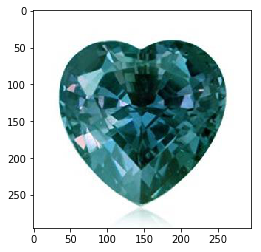

EnforceNotMet: 

--------------------------------------------
C++ Call Stacks (More useful to developers):
--------------------------------------------
0   std::string paddle::platform::GetTraceBackString<std::string const&>(std::string const&, char const*, int)
1   paddle::platform::EnforceNotMet::EnforceNotMet(std::string const&, char const*, int)
2   paddle::operators::ReshapeOp::ValidateShape(std::vector<int, std::allocator<int> >, paddle::framework::DDim const&)
3   paddle::operators::ReshapeOp::InferShape(paddle::framework::InferShapeContext*) const
4   paddle::operators::Reshape2Op::InferShape(paddle::framework::InferShapeContext*) const
5   paddle::imperative::PreparedOp::Run(paddle::imperative::NameVarBaseMap const&, paddle::imperative::NameVarBaseMap const&, paddle::framework::AttributeMap const&)
6   paddle::imperative::OpBase::Run(paddle::framework::OperatorBase const&, paddle::imperative::NameVarBaseMap const&, paddle::imperative::NameVarBaseMap const&, paddle::framework::AttributeMap const&, paddle::platform::Place const&)
7   paddle::imperative::Tracer::TraceOp(std::string const&, paddle::imperative::NameVarBaseMap const&, paddle::imperative::NameVarBaseMap const&, paddle::framework::AttributeMap, paddle::platform::Place const&, bool)
8   paddle::imperative::Tracer::TraceOp(std::string const&, paddle::imperative::NameVarBaseMap const&, paddle::imperative::NameVarBaseMap const&, paddle::framework::AttributeMap)

----------------------
Error Message Summary:
----------------------
InvalidArgumentError: The 'shape' attribute in ReshapeOp is invalid. The input tensor X'size must be divisible by known capacity of 'shape'. But received X's shape = [1, 3, 224, 224], X's size = 150528, 'shape' is [-1, 12288], known capacity of 'shape' is -12288.
  [Hint: Expected output_shape[unk_dim_idx] * capacity == -in_size, but received output_shape[unk_dim_idx] * capacity:-147456 != -in_size:-150528.] at (/paddle/paddle/fluid/operators/reshape_op.cc:192)
  [operator < reshape2 > error]

In [20]:
label_dic = train_parameters['label_dict']

'''
模型预测
'''
with fluid.dygraph.guard():
    model_dict, _ = fluid.load_dygraph('MyDNN')
    model = MyDNN()
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    
    #展示预测图片
    infer_path='data/archive_test/alexandrite_3.jpg'
    img = Image.open(infer_path)
    plt.imshow(img)          #根据数组绘制图像
    plt.show()               #显示图像

    #对预测图片进行预处理
    infer_imgs = []
    infer_imgs.append(load_image(infer_path))
    infer_imgs = np.array(infer_imgs)
   
    for i in range(len(infer_imgs)):
        data = infer_imgs[i]
        dy_x_data = np.array(data).astype('float32')
        dy_x_data=dy_x_data[np.newaxis,:, : ,:]
        img = fluid.dygraph.to_variable(dy_x_data)
        out = model(img)
        lab = np.argmax(out.numpy())  #argmax():返回最大数的索引

        print("第{}个样本,被预测为：{},真实标签为：{}".format(i+1,label_dic[str(lab)],infer_path.split('/')[-1].split("_")[0]))
        
print("结束")